# Part 4: Gene expression

This notebook generates the items listed below. For preprocessing see:

Figures: 
* Figure 4 panels b-f

Supplementary Figures:

Supplementary Tables:
* Supp Table 12: significant eTRs in EUR
* Supp Table 13: significant eTRs in AFR


Statistics:



In [1]:
####### Set up #########


%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest


PLOTDIR = "pdfs"

eur = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/EUR_eSTR_regression_with_gender.csv", sep="\t")
afr = pd.read_csv("/storage/yal084/geuvidas_eQTL/results/AFR_eSTR_regression_with_gender.csv", sep="\t")

# basic filtering
eur = eur[(eur["sample_n"]>=50) & (~np.isnan(eur["p_values"]))]
afr = afr[(afr["sample_n"]>=50) & (~np.isnan(afr["p_values"]))]

# Remove near-duplicates
eur["chrom"] = eur["str-gene"].apply(lambda x: (x.split("_")[0]))
eur["start"] = eur["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
eur["start_rounded"] = eur["start"].apply(lambda x: int(x/20)*20)
# eur = eur.drop_duplicates(subset=["chrom","start_rounded","gene_name"])
eur=eur.loc[eur.groupby(['chrom','start_rounded','gene_name'])['p_values'].idxmin()]
eur = eur.drop(["chrom","start","start_rounded"], axis=1)

afr["chrom"] = afr["str-gene"].apply(lambda x: (x.split("_")[0]))
afr["start"] = afr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
afr["start_rounded"] = afr["start"].apply(lambda x: int(x/20)*20)
# afr = afr.drop_duplicates(subset=["chrom","start_rounded","gene_name"])
afr=afr.loc[afr.groupby(['chrom','start_rounded','gene_name'])['p_values'].idxmin()]
afr = afr.drop(["chrom","start","start_rounded"], axis=1)



Populating the interactive namespace from numpy and matplotlib


# Data preparation
## Prepare data for Figure 4 b: Comparison of effect sizes across populations

In [6]:
FDRTHRESH = 0.05

def GetGeneLevelFDR(df, fdrthresh=0.05, prefix=None):
    # Get best pval per gene, and adjustment factor
    bygene = df.groupby(["gene_name"], as_index=False).agg({"str-gene": len})
    # Bonferroni adjusted for number of STRs tested
    bygene = bygene.rename({"str-gene": "num.strs.tested"}, axis=1)
    # merge back to main df
    xx = pd.merge(df, bygene[["gene_name","num.strs.tested"]], on=["gene_name"], how="outer")
    # Bonferonni adjustment of pvalues
    xx["genelevel.bf.adj.p"] = xx.apply(lambda x: np.min([1, x["p_values"]*x["num.strs.tested"]]), 1)
    # Find the best STR per gene and do FDR on that
    bestps = xx.groupby(["gene_name"], as_index=False).agg({"genelevel.bf.adj.p": np.min})
    bestps["genelevel.p.adj"] = \
        statsmodels.stats.multitest.multipletests(list(bestps["genelevel.bf.adj.p"]), \
                                                  method="fdr_bh")[1]
    bestps = bestps.rename({"genelevel.p.adj": "best.genelevel.p.adj", 
                           "genelevel.bf.adj.p": "best.genelevel.bf.adj.p"}, axis=1)
    # Merge back to the main one
    xx = pd.merge(xx, bestps, on=["gene_name"])
    xx.shape
    xx["best.str"] = (xx["genelevel.bf.adj.p"]==xx["best.genelevel.bf.adj.p"])
    # Determine significance
    xx["sig.genelevel"] = xx.apply(lambda x: x["best.str"] and (x["best.genelevel.p.adj"]<fdrthresh), 1)
    # Drop eTRs have identical p_values but different TR associated with
    duplicated_genes=xx[xx['best.str'] & xx['sig.genelevel']][xx[xx['best.str'] & xx['sig.genelevel']].\
                duplicated(subset=['gene_name','sample_n','GT_n','p_values'])].index.tolist()
    xx.loc[duplicated_genes,'sig.genelevel']=False
#     xx=xx[xx['best.str'] & xx['sig.genelevel']].\
#             drop_duplicates(subset=['gene_name','sample_n','GT_n','p_values'])
    print("Identified %s eSTRs at gene-level FDR (%s): %s"%(np.sum(xx["sig.genelevel"]), prefix, fdrthresh))
    return xx

########### Not collapsed by gene #############################
eur["p.adj"] = statsmodels.stats.multitest.multipletests(list(eur["p_values"]), method="fdr_bh")[1]
afr["p.adj"] = statsmodels.stats.multitest.multipletests(list(afr["p_values"]), method="fdr_bh")[1]

print("Num eTR - EUR: %s"%eur[eur["p.adj"]<FDRTHRESH].shape[0])
print("Num eTR - AFR: %s"%afr[afr["p.adj"]<FDRTHRESH].shape[0])

########### Gene-level FDR ####################################
eur_fdr = GetGeneLevelFDR(eur, prefix="EUR")
afr_fdr = GetGeneLevelFDR(afr, prefix="AFR")

# Merge for comparison
cols = ["str-gene", "gene_name", "sample_n","p_values","slope","error","p.adj","best.str","sig.genelevel","best.genelevel.p.adj"]
data = pd.merge(eur_fdr[cols], afr_fdr[cols], on=["str-gene","gene_name"], suffixes=("_EUR", "_AFR"), how="outer")

# the 
# PTHRESH = 0.05/data.shape[0]
# print(PTHRESH)
pltdata = data[(data["p.adj_EUR"]<FDRTHRESH) | (data["p.adj_AFR"]<FDRTHRESH)]
pltdata = pltdata[pltdata["slope_AFR"].apply(abs) < 1]
pltdata = pltdata[pltdata["slope_EUR"].apply(abs) < 1]

def GetColor(x, col1="slope_EUR", col2="slope_AFR"):
    if np.sign(x[col1])==np.sign(x[col2]):
        return "red"
    else: return "gray"

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(pltdata["slope_EUR"], pltdata["slope_AFR"], color=pltdata.apply(GetColor, 1), s=2, alpha=0.5);
# ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
# ax.set_xlabel("Effect size (GEUVADIS-EUR)",fontsize=12)
# ax.set_ylabel("Effect size (GEUVADIS-AFR)",fontsize=12)
print(scipy.stats.pearsonr(pltdata["slope_EUR"], pltdata["slope_AFR"]))
# fig.savefig(os.path.join(PLOTDIR, "Figure4b-Geuvadis-AFRVsEUR.pdf"))

Num eTR - EUR: 55361
Num eTR - AFR: 342
Identified 3644 eSTRs at gene-level FDR (EUR): 0.05
Identified 72 eSTRs at gene-level FDR (AFR): 0.05
(0.41855223571060535, 0.0)


In [12]:
afr_fdr[(afr_fdr.slope.abs()>1) & (afr_fdr['p.adj']<0.05)]

,str-gene,gene_name,sample_n,GT_n,p_values,slope,error,shuffled_p,shuffled_slope,shuffled_error,p.adj,num.strs.tested,genelevel.bf.adj.p,best.genelevel.bf.adj.p,best.genelevel.p.adj,best.str,sig.genelevel


## Prepare data for figure 4 c-d: Comparison of effect sizes in GEUVADIS vs. GTEx

In [ ]:
### check the why remove Nan cause the different of effect size correlation
# v0_eur_merged=eur_merged.copy()
# v0_afr_merged=afr_merged.copy()
# oldgtex=gtex.copy()
# v0_afr_merged.loc[1615]['linreg.pval.adj']<0.05
# afr_merged[afr_merged.gene_name=='ARHGEF19']

In [13]:
# List of Tissues that analyzed in GTEx data
TISSUES = [
    "Adipose-Subcutaneous",
    "Adipose-Visceral",
    "Artery-Aorta",
    "Artery-Tibial",
    "Brain-Caudate",
    "Brain-Cerebellum",
    "Cells-Transformedfibroblasts",
    "Esophagus-Mucosa",
    "Esophagus-Muscularis",
    "Heart-LeftVentricle",
    "Lung",
    "Muscle-Skeletal",
    "Nerve-Tibial",
    "Skin-NotSunExposed",
    "Skin-SunExposed",
    "Thyroid",
    "WholeBlood"
]

###### Load GTEx data ###########
gtex = {} # tissue -> df
gtex_eTRs=[]# eTRs at gene level
gtex_allTRs=[] # all tested TR-gene pairs
for t in TISSUES:
    df = pd.read_csv("/storage/yal084/geuvidas_eQTL/gtex_estr/raw/master/%s_master.tab"%t, sep="\t",low_memory=False)
    lift = pd.read_csv("/storage/yal084/geuvidas_eQTL/gtex_estr/liftover/%s_hg38.bed"%t, sep="\t", names=["chrom","start_hg38","x","hg19_coords"])
    lift["str.start"] = lift["hg19_coords"].apply(lambda x: int(x.split(":")[1]))
    lift = lift.drop_duplicates()
    df = pd.merge(df, lift[["chrom","str.start","start_hg38"]], on=["chrom","str.start"])
    df = df.rename({"gene.name": "gene_name"}, axis=1)
    #Remove STRs both p.val and beta is null
    df = df[(~df["linreg.pval"].isnull()) & (~df["linreg.beta"].isnull())]
    #nan p.val leads to a lot of eTRs have nan in q-values
    df["linreg.pval.adj"] = statsmodels.stats.multitest.multipletests(list(df["linreg.pval"]), \
                                                     method="fdr_bh")[1]
    df["start_hg38_rounded"] = df["start_hg38"].apply(lambda x: int(x/20)*20)
    ###Get the gene level eTRs for comparision
    #Get eTRs at gene level 
    df_eTRs=df[df['linreg.qval']<FDRTHRESH].copy()
#     df_eTRs=df[df['linreg.significant']].copy()
    df_eTRs["eTR_id"]=df_eTRs["chrom"]+'_'+df_eTRs["start_hg38_rounded"].astype(str)+'_'+df_eTRs["gene_name"]

    gtex_eTRs=gtex_eTRs+df_eTRs["eTR_id"].tolist()
    gtex_allTRs=df["chrom"]+'_'+df["start_hg38_rounded"].astype(str)+'_'+df["gene_name"]
    gtex[t] = df
    
eur_fdr["start_hg38"] = eur_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
eur_fdr["chrom"] = eur_fdr["str-gene"].apply(lambda x: x.split("_")[0])

afr_fdr["start_hg38"] = afr_fdr["str-gene"].apply(lambda x: int(x.split("_")[1].split("-")[0]))
afr_fdr["chrom"] = afr_fdr["str-gene"].apply(lambda x: x.split("_")[0])


def MergeGTExGeuvadis(gtex, geu):
    # Round coordinates in case off by a bit
    R = 20
    geu["start_hg38_rounded"] = geu["start_hg38"].apply(lambda x: int(x/R)*R)
    gtex["start_hg38_rounded"] = gtex["start_hg38"].apply(lambda x: int(x/R)*R)
    # Merge on rounded coords and gene
    merged = pd.merge(geu[["chrom","start_hg38_rounded","start_hg38","gene_name","slope","p_values","p.adj"]], \
                        gtex[["chrom","start_hg38_rounded","gene_name","linreg.beta","linreg.pval","linreg.pval.adj"]])
    merged = merged[~np.isnan(merged["linreg.beta"]) & ~np.isnan(merged["slope"])]
    
    # Require some significance threshold in either
    merged = merged[(merged["p.adj"]<FDRTHRESH) | (merged["linreg.pval.adj"]<FDRTHRESH)]
    return merged

for t in TISSUES:
    ### Here compare the gene leve with eTR level?
    eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
    afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)
    
    print("##### %s ########"%t)
    r_eur, p_eur = scipy.stats.pearsonr(eur_merged["slope"], eur_merged["linreg.beta"])
    print("EUR n=%s r=%.2f p=%.2g"%(eur_merged.shape[0], r_eur, p_eur))
    r_afr, p_afr = scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
    print("AFR n=%s r=%.2f p=%.2g"%(afr_merged.shape[0], r_afr, p_afr))
    
    
# gtex_eTRs=[] # tissue -> df
# for t in TISSUES:
#     df = pd.read_csv("/storage/yal084/geuvidas_eQTL/gtex_estr/raw/master/%s_master.tab"%t, sep="\t",low_memory=False)
#     lift = pd.read_csv("/storage/yal084/geuvidas_eQTL/gtex_estr/liftover/%s_hg38.bed"%t, sep="\t", names=["chrom","start_hg38","x","hg19_coords"])
#     lift["str.start"] = lift["hg19_coords"].apply(lambda x: int(x.split(":")[1]))
#     lift = lift.drop_duplicates()
#     df = pd.merge(df, lift[["chrom","str.start","start_hg38"]], on=["chrom","str.start"])
#     df = df.rename({"gene.name": "gene_name"}, axis=1)
#     df = df[~df["linreg.pval"].isnull()]
#     df["linreg.pval.adj"] = statsmodels.stats.multitest.multipletests(list(df["linreg.pval"]), \
#                                                   method="fdr_bh")[1]
#     df_eTRs=df[df["linreg.pval.adj"]<FDRTHRESH].copy()
#     df_eTRs["start_hg38_rounded"] = df_eTRs["start_hg38"].apply(lambda x: int(x/20)*20)
#     df_eTRs["eTR_id"]=df_eTRs["chrom"]+'_'+df_eTRs["start_hg38_rounded"].astype(str)+'_'+df_eTRs["gene_name"]

#     gtex_eTRs=gtex_eTRs+df_eTRs["eTR_id"].tolist()
# gtex_eTRs=set(gtex_eTRs)

##### Adipose-Subcutaneous ########
EUR n=20176 r=0.42 p=0
AFR n=7468 r=0.25 p=4.3e-110
##### Adipose-Visceral ########
EUR n=16583 r=0.43 p=0
AFR n=3606 r=0.31 p=2e-82
##### Artery-Aorta ########
EUR n=18173 r=0.39 p=0
AFR n=5364 r=0.24 p=3.4e-73
##### Artery-Tibial ########
EUR n=20898 r=0.38 p=0
AFR n=8166 r=0.23 p=2.4e-100
##### Brain-Caudate ########
EUR n=14010 r=0.34 p=0
AFR n=1345 r=0.30 p=9.2e-29
##### Brain-Cerebellum ########
EUR n=15413 r=0.29 p=1.6e-296
AFR n=2939 r=0.18 p=2.4e-22
##### Cells-Transformedfibroblasts ########
EUR n=19481 r=0.47 p=0
AFR n=7312 r=0.29 p=7.1e-144
##### Esophagus-Mucosa ########
EUR n=19421 r=0.44 p=0
AFR n=6592 r=0.28 p=1.7e-117
##### Esophagus-Muscularis ########
EUR n=18477 r=0.42 p=0
AFR n=5830 r=0.28 p=9.1e-102
##### Heart-LeftVentricle ########
EUR n=16468 r=0.39 p=0
AFR n=3628 r=0.27 p=2e-59
##### Lung ########
EUR n=19399 r=0.44 p=0
AFR n=6598 r=0.28 p=5.4e-120
##### Muscle-Skeletal ########
EUR n=20318 r=0.36 p=0
AFR n=7370 r=0.21 p=2.2

In [15]:
##select only eTR gene-levels
eur_eTRs=eur_fdr[eur_fdr['sig.genelevel']].copy()
afr_eTRs=afr_fdr[afr_fdr['sig.genelevel']].copy()
#Get eTRs in EUR and AFR corhorts
eur_eTRs["start_hg38_rounded"] = eur_eTRs["start_hg38"].apply(lambda x: int(x/20)*20)
afr_eTRs["start_hg38_rounded"] = afr_eTRs["start_hg38"].apply(lambda x: int(x/20)*20)
eur_eTRs["eTR_id"]=eur_eTRs["chrom"]+'_'+eur_eTRs["start_hg38_rounded"].astype(str)+'_'+eur_eTRs["gene_name"]
afr_eTRs["eTR_id"]=afr_eTRs["chrom"]+'_'+afr_eTRs["start_hg38_rounded"].astype(str)+'_'+afr_eTRs["gene_name"]

new_eTRs=set(eur_eTRs["eTR_id"].tolist()+afr_eTRs["eTR_id"].tolist())

In [16]:
print(f'{len(new_eTRs-set(gtex_eTRs))} eTRs found in ensembleTR,\
\n{len((new_eTRs-set(gtex_eTRs))-set(gtex_allTRs))} TRs not tested in previous study,\
\n{len(new_eTRs-set(gtex_eTRs))-len((new_eTRs-set(gtex_eTRs))-set(gtex_allTRs))} TRs Not tested in previous study')

2868 eTRs found in ensembleTR,
2701 TRs not tested in previous study,
167 TRs Not tested in previous study


In [17]:
# Plot correlation with Cells-Transformedfibroblasts, which had best correlation above
t = "Cells-Transformedfibroblasts"
eur_merged = MergeGTExGeuvadis(gtex[t], eur_fdr)
afr_merged = MergeGTExGeuvadis(gtex[t], afr_fdr)

# fig = plt.figure()
# fig.set_size_inches((10, 4))

# ax = fig.add_subplot(121)
# ax.scatter(eur_merged["slope"], eur_merged["linreg.beta"], s=3, 
#            color=eur_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
# ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
# ax.set_xlabel("Effect size (GEUVADIS-EUR)",fontsize=12)
# ax.set_ylabel("Effect size (GTEx)",fontsize=12)

# ax = fig.add_subplot(122)
# ax.scatter(afr_merged["slope"], afr_merged["linreg.beta"], s=3, 
#            color=afr_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
# ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.axhline(y=0, linestyle="dashed", color="black", linewidth=0.5)
# ax.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=0.5)
# ax.set_xlabel("Effect size (GEUVADIS-AFR)",fontsize=12)
# ax.set_ylabel("Effect size (GTEx)",fontsize=12)
# fig.tight_layout()
# fig.savefig(os.path.join(PLOTDIR, "Figure4c-d-Geuvadis-Vs-GTEx-%s.pdf"%t))

## Prepare data for figure 4 e-f: Example novel eTR

In [19]:
AFR_COLOR = "red"
EUR_COLOR = "blue"

def get_str_exp_values(str_gene,pop='EUR',minsPgt=3):
    """
    input str-gene pairs and population
    extract the genotypes: sum of alleles output the expression 
    """
    
    chrom=str_gene.split('_')[0]
    pos=int(str_gene.split('-')[0].split('_')[1])
    gene_id=str_gene.split('-')[1]
    
    gt_dir='/storage/yal084/geuvidas_eQTL/ensemble_call/GB_info/'\
        +str(chrom)+'.GB.FORMAT'
    exp_df=pd.read_csv('/storage/yal084/geuvidas_eQTL/normalized_expression/'+pop+'_normalized_and_filtered_hg38.csv',sep='\t')
    exp_df=exp_df[exp_df.gene_id==gene_id]
    
    all_STR=pd.read_csv(gt_dir,sep='\t')
    select_STR=all_STR[all_STR.POS==pos].copy()
    select_STR[select_STR.columns[2:]]=select_STR[select_STR.columns[2:]]. \
                    applymap(lambda x: [int(x.split('/')[0]),int(x.split('/')[1])] if '/' in x else [None,None])
    select_STR=select_STR[['CHROM','POS']+select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()]
    gt_samples=select_STR.columns[2:][select_STR.iloc[0,2:].apply(lambda x: x !=[None,None])].to_list()
    gt_samples=list(set(gt_samples) & set(exp_df.columns.tolist()))
    select_STR_phased=select_STR[gt_samples].T.rename \
                        (columns={select_STR.index.to_list()[0]:'GT'}).applymap(lambda x: sum(x))
    gt_sum=select_STR_phased.groupby('GT').size()
    gt_ab_3=gt_sum[gt_sum>=minsPgt].index.tolist()
    final_filted_samples=set(select_STR_phased[select_STR_phased.GT.isin(gt_ab_3)].index)
    final_phased_STR=select_STR_phased.loc[final_filted_samples].copy()
    
    return final_phased_STR.values.reshape(-1),exp_df[final_filted_samples].values.reshape(-1)

def GetSummary(gts, exprs):
    gtvals = sorted(list(set(gts)))
    evals = []
    for gtval in gtvals:
        evals.append(np.median([exprs[i] for i in range(len(exprs)) if gts[i]==gtval]))
    return gtvals, evals

def AddNoise(items):
    return [item + np.random.uniform(0, 0.1) for item in items]

def plot_eTR(str_gene,ax,motif,gene_name):
    afr_str, afr_expr = get_str_exp_values(str_gene,pop='AFR')
    eur_str, eur_expr = get_str_exp_values(str_gene,pop='EUR')

    afr_str_summ, afr_expr_summ = GetSummary(afr_str, afr_expr)
    eur_str_summ, eur_expr_summ = GetSummary(eur_str, eur_expr)

    buf = 0.5

#     fig = plt.figure()
#     ax = fig.add_subplot(111)
    ax.scatter(AddNoise([item-buf for item in afr_str]),afr_expr,color=AFR_COLOR, alpha=0.2,s=20) 
    ax.plot(afr_str_summ, afr_expr_summ, color=AFR_COLOR, marker="o", label="AFR")
    ax.scatter(AddNoise([item+buf for item in eur_str]),eur_expr,color=EUR_COLOR, alpha=0.2,s=20) 
    ax.plot(eur_str_summ, eur_expr_summ, color=EUR_COLOR, marker="o", label="EUR")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend()
    ax.set_xlabel("sum of repeat copies (%s)"%motif)
    ax.set_ylabel("Normalized expression")
    ax.set_title(gene_name,fontsize=20)

# ##plotting 
# fig = plt.figure(constrained_layout=True)
# fig.set_size_inches((8, 4))
# gs = GridSpec(1, 2, figure=fig)

# ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[0,1])

# plot_eTR('chr21_43776443-ENSG00000160213.5',ax1,'CCCCGG$_\mathrm{n}$','CSTB')
# plot_eTR('chr11_57528484-ENSG00000134809.4',ax2,'AT$_\mathrm{n}$','TIMM10')
# title_ef="example eTRs"
# fig.savefig(os.path.join(PLOTDIR, "Figure4e-f-%s.pdf"%title_ef))



# Plot: Figure 4 b-f "TRs associated with gene expression in LCLs"

In [21]:
afr_merged[afr_merged["slope"].abs()<1]

,chrom,start_hg38_rounded,start_hg38,gene_name,slope,p_values,p.adj,linreg.beta,linreg.pval,linreg.pval.adj
18,chr1,950660,950660,PLEKHN1,0.046601,0.759435,0.986696,-0.218429,9.994578e-04,2.478146e-02
30,chr1,1010740,1010748,ISG15,0.063716,0.233307,0.907932,-0.243833,4.706263e-04,1.381943e-02
44,chr1,1063640,1063646,C1orf159,0.031234,0.810397,0.990428,-0.234404,4.282700e-04,1.281099e-02
99,chr1,1388560,1388566,ANKRD65,-0.277506,0.195042,0.894210,-0.311453,4.196326e-06,2.653823e-04
100,chr1,1403240,1403241,ANKRD65,0.377596,0.033637,0.720427,0.428884,4.950633e-11,1.012344e-08
...,...,...,...,...,...,...,...,...,...,...
136779,chr9,137257800,137257801,C9orf173,0.354617,0.099427,0.836044,0.209615,1.645796e-03,3.628032e-02
136788,chr9,137443860,137443870,EXD3,0.123432,0.496503,0.961440,-0.227463,1.306643e-03,3.040857e-02
136795,chr9,137611560,137611563,PNPLA7,0.098224,0.549487,0.967719,-0.379028,9.417799e-09,1.190301e-06
136799,chr9,137611560,137611563,ZMYND19,-0.007156,0.954773,0.997777,0.221848,1.057073e-03,2.584051e-02


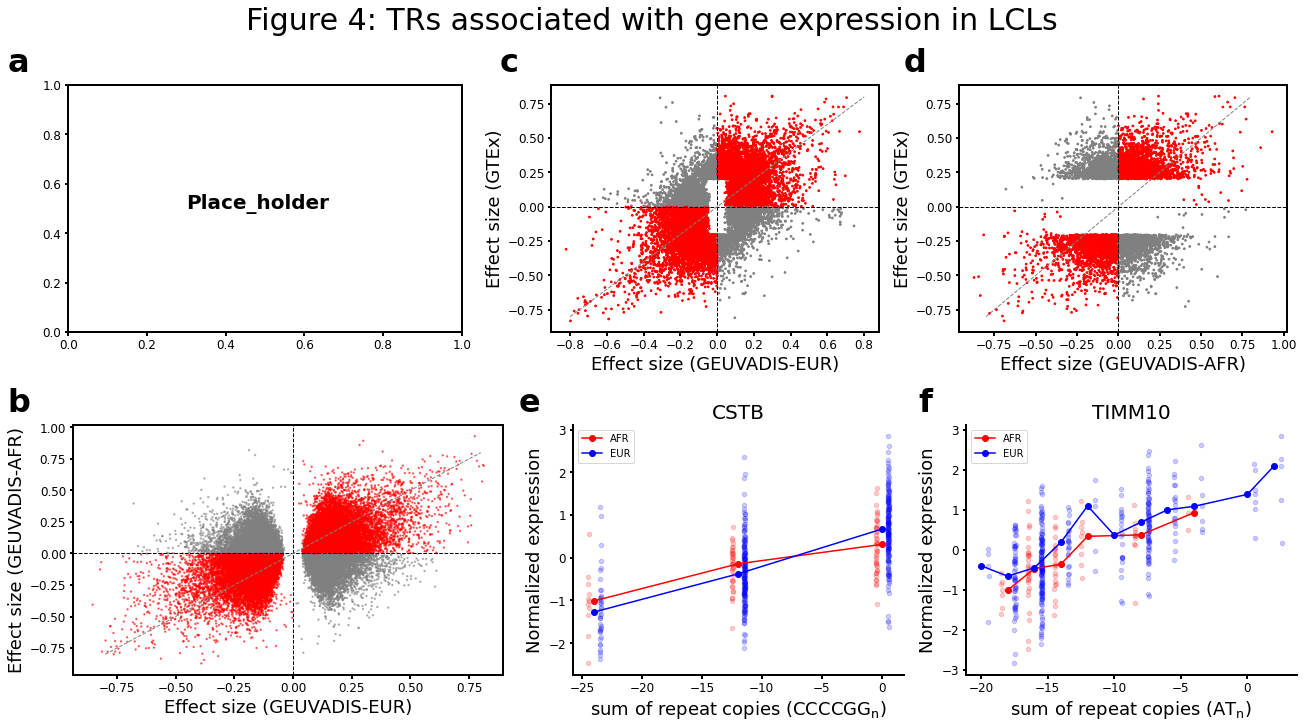

In [25]:
sub_lenged=['a','c','d','b','e','f']

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        if i==0:
            ax.text(0.3, 0.5, "Place_holder", transform=ax.transAxes, 
                    size=20, fontweight="bold", family="sans-serif")
        #add f
        if i<6:
            labtext = sub_lenged[i]
            ax.text(-0.1, 1.15, labtext, transform=ax.transAxes, 
                         size=32, fontweight="bold", family="sans-serif",
                        va="top", ha="right")
            ax.tick_params(width=2)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(2)


###set up figure
LABSIZE = 18
TICKSIZE = 12
parameters = {'axes.labelsize': LABSIZE,
              'xtick.labelsize': TICKSIZE,
              'ytick.labelsize':TICKSIZE}
plt.rcParams.update(parameters)

fig = plt.figure(constrained_layout=True)
fig.set_size_inches((18, 10))
gs = GridSpec(2, 3,width_ratios=[1.2,1,1], figure=fig)
gs0 = GridSpecFromSubplotSpec(1, 3, width_ratios=[1.3,1,1], subplot_spec=gs[1,:])

###setup subplot
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs0[0,0])
ax5 = fig.add_subplot(gs0[0,1])
ax6 = fig.add_subplot(gs0[0,2])      
fig.suptitle("GridSpec")

#plotting Figure4b-Geuvadis-AFRVsEUR
ax4.scatter(pltdata["slope_EUR"], pltdata["slope_AFR"], color=pltdata.apply(GetColor, 1), s=2, alpha=0.5);
ax4.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax4.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax4.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
ax4.set_xlabel("Effect size (GEUVADIS-EUR)")
ax4.set_ylabel("Effect size (GEUVADIS-AFR)")

# scipy.stats.pearsonr(afr_merged["slope"], afr_merged["linreg.beta"])
#plotting Figure4b-Geuvadis-AFRVsEUR, remove eTRs with slope large than 1
afr_merged_plot=afr_merged[afr_merged["slope"].abs()<1].copy()
ax3.scatter(afr_merged_plot["slope"], afr_merged_plot["linreg.beta"], s=3, 
           color=afr_merged_plot.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax3.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax3.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax3.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
ax3.set_xlabel("Effect size (GEUVADIS-AFR)")
ax3.set_ylabel("Effect size (GTEx)")

##
ax2.scatter(eur_merged["slope"][eur_merged["slope"].abs()<1], eur_merged[eur_merged["slope"].abs()<1]["linreg.beta"], s=3, 
           color=eur_merged.apply(lambda x: GetColor(x, col1="slope", col2="linreg.beta"), 1))
ax2.axvline(x=0, linestyle="dashed", color="black", linewidth=1)
ax2.axhline(y=0, linestyle="dashed", color="black", linewidth=1)
ax2.plot([-0.8, 0.8], [-0.8, 0.8], linestyle="dashed", color="gray", linewidth=1)
ax2.set_xlabel("Effect size (GEUVADIS-EUR)")
ax2.set_ylabel("Effect size (GTEx)")

##
plot_eTR('chr21_43776443-ENSG00000160213.5',ax5,'CCCCGG$_\mathrm{n}$','CSTB')
plot_eTR('chr11_57528484-ENSG00000134809.4',ax6,'AT$_\mathrm{n}$','TIMM10')

##add titles and formating
fig.suptitle('Figure 4: TRs associated with gene expression in LCLs',fontsize=30)
format_axes(fig)
plt.show()
fig.savefig(os.path.join(PLOTDIR, "Figure4b-fTRsAssociatedWithGeneExpressionInLCLs.pdf"))

# Supp Table 12-13 and Dataset 1

In [12]:
def combine_cohorts(row):
    """
    best_str:populations
    regression_info:population_SampleN_Pvalues_Slope_Padjust"
    """
    pop_list=np.array(['EUR','AFR'])
    best_str=','.join(pop_list[np.array([row['best.str_EUR'],row['best.str_AFR']])==True])
    if np.isnan(row["sample_n_EUR"]):
        EUR_info=[]
    else:
        EUR_info=['_'.join([str(i) for i in ['EUR',int(row['sample_n_EUR']),row['p_values_EUR'],row['slope_EUR'],'p.adj_EUR']])]
    if np.isnan(row["sample_n_AFR"]):
        AFR_info=[]
    else:
        AFR_info=['_'.join([str(i) for i in ['AFR',int(row['sample_n_AFR']),row['p_values_AFR'],row['slope_AFR'],'p.adj_AFR']])]
        
    return [best_str,','.join(AFR_info+EUR_info)]

#Add the end coordinate of TRs and save to excel files
TRs_coordinate=pd.read_csv('/storage/yal084/geuvidas_eQTL/TRs_coordinate_motif.txt',sep='\t',names=['chrom','start','end','motif'])
TRs_coordinate=TRs_coordinate.drop_duplicates()
TRs_coordinate['str_id']=TRs_coordinate['chrom']+'_'+TRs_coordinate['start'].astype(str)
TRs_pos_dict=dict(zip(TRs_coordinate['str_id'],TRs_coordinate['end']))
TRs_coordinate=TRs_coordinate.groupby(['chrom','start','end'],as_index=False).agg({'motif':lambda x: ','.join(x)})

eur_eTRs=eur[eur['p.adj']<FDRTHRESH].drop(columns=['shuffled_p','shuffled_slope','shuffled_error'])
eur_eTRs.reset_index(drop=True,inplace=True)
eur_eTRs['str_end']=eur_eTRs['str-gene'].str.split('-',expand=True)[0].map(TRs_pos_dict)

afr_eTRs=afr[afr['p.adj']<FDRTHRESH].drop(columns=['shuffled_p','shuffled_slope','shuffled_error'])
afr_eTRs.reset_index(drop=True,inplace=True)
afr_eTRs['str_end']=eur_eTRs['str-gene'].str.split('-',expand=True)[0].map(TRs_pos_dict)

eur_eTRs.to_csv(os.path.join(PLOTDIR, 'eur_eTRs.csv'),sep='\t',index=False)
afr_eTRs.to_csv(os.path.join(PLOTDIR, 'afr_eTRs.csv'),sep='\t',index=False)

data['end']=data['str-gene'].str.split('-',expand=True)[0].map(TRs_pos_dict)
data[['chrom','start']]=data['str-gene'].str.split('-',expand=True)[0].str.split('_',expand=True)
data['start']=data['start'].astype(int)
data=data.merge(TRs_coordinate.drop_duplicates(), on=['chrom','start','end'],how='left')
data['gene_id']=data['str-gene'].str.split('-',expand=True)[1]
data[['best_str','regression_info']]=data.apply(lambda x: combine_cohorts(x),axis=1,result_type='expand')
#Save files
all_eTR=data[['chrom','start','end','gene_id','gene_name','best_str','regression_info','motif']].copy()
all_eTR.to_csv(os.path.join(PLOTDIR, 'all_eTRs.csv'),sep='\t',index=False)

In [10]:
TRs_coordinate

,chrom,start,end,str_id
0,chr1,902774,902788,chr1_902774
1,chr1,907237,907250,chr1_907237
2,chr1,914949,914985,chr1_914949
3,chr1,919012,919023,chr1_919012
4,chr1,920640,920655,chr1_920640
...,...,...,...,...
1440099,chr22,50733151,50733189,chr22_50733151
1440100,chr22,50734873,50734887,chr22_50734873
1440101,chr22,50735036,50735052,chr22_50735036
1440102,chr22,50735363,50735374,chr22_50735363
